=== 入力データの例 ===
tensor([[14.3708, 14.2382, 18.7471, 17.8306, 24.2436, 23.4600, 18.4199,  9.4239,
         21.6114, 13.6833],
        [21.7499, 21.5407, 20.5992, 26.1883, 25.5839, 18.7636, 13.2367, 11.5203,
         22.8333, 23.9675],
        [22.9942, 12.2245, 18.2932, 29.2650, 18.9207, 16.2873, 22.8136, 21.2981,
         19.1302, 16.6063],
        [24.6913, 22.4443, 26.0161, 20.4227, 13.9993, 19.9761, 17.4096, 18.4665,
         12.0950, 28.5332]])

=== 平均と分散の比較 ===
Before normalization: mean=tensor([17.6029, 20.5983, 19.7833, 20.4054]), var=tensor([22.2808, 23.8481, 21.6147, 27.0097])
After normalization : mean=tensor([-2.6226e-07,  0.0000e+00,  4.7386e-07,  9.2387e-08],
       grad_fn=<MeanBackward1>), var=tensor([1.1111, 1.1111, 1.1111, 1.1111], grad_fn=<VarBackward0>)


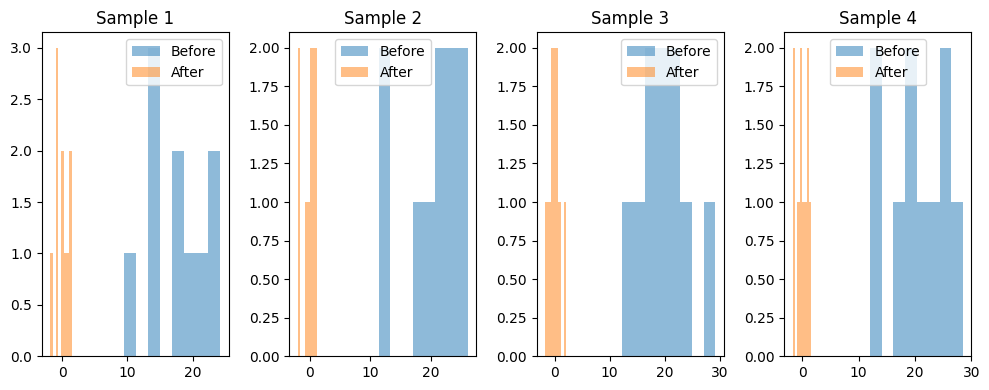

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ====== 1. 入力データを準備 ======
torch.manual_seed(0)
x = torch.randn(4, 10) * 5 + 20   # バッチサイズ4, 特徴数10
print("=== 入力データの例 ===")
print(x)

# ====== 2. LayerNormを適用 ======
layer_norm = nn.LayerNorm(10)
y = layer_norm(x)

# ====== 3. 統計を比較 ======
print("\n=== 平均と分散の比較 ===")
print(f"Before normalization: mean={x.mean(dim=1)}, var={x.var(dim=1)}")
print(f"After normalization : mean={y.mean(dim=1)}, var={y.var(dim=1)}")

# ====== 4. 可視化 ======
plt.figure(figsize=(10,4))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(x[i].detach().numpy(), bins=8, alpha=0.5, label='Before')
    plt.hist(y[i].detach().numpy(), bins=8, alpha=0.5, label='After')
    plt.title(f'Sample {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()



### 🔍 詳細解説

Layer Normalization の数式は以下の通りです：

$$
y_i = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

ここで：

* ( x_i ): 入力特徴量
* ( \mu ): 入力の平均（各サンプルごとに計算）
* ( \sigma^2 ): 入力の分散（各サンプルごとに計算）
* ( \epsilon ): 数値安定化のための小さい値
* ( \gamma, \beta ): **学習可能パラメータ**

---

### 💡 つまり：

| 要素      | 役割                | 学習される？  |
| ------- | ----------------- | ------- |
| μ（平均）   | 入力を正規化するためにその都度計算 | ❌ されない  |
| σ²（分散）  | 入力を正規化するためにその都度計算 | ❌ されない  |
| γ（スケール） | 正規化後の値を伸縮する       | ✅ 学習される |
| β（バイアス） | 正規化後の値を平行移動する     | ✅ 学習される |



In [2]:
import torch
import torch.nn as nn

# 入力テンソル (バッチサイズ2, 特徴次元4)
x = torch.randn(2, 4)

# LayerNorm (特徴次元4)
ln = nn.LayerNorm(4)

# 学習可能パラメータを確認
print("gamma (weight):", ln.weight)
print("beta (bias):", ln.bias)

# 勾配を確認する
y = ln(x)
loss = y.mean()
loss.backward()

print("gamma.grad:", ln.weight.grad)
print("beta.grad:", ln.bias.grad)


gamma (weight): Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
beta (bias): Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)
gamma.grad: tensor([ 0.1131, -0.0149, -0.2541,  0.1559])
beta.grad: tensor([0.2500, 0.2500, 0.2500, 0.2500])


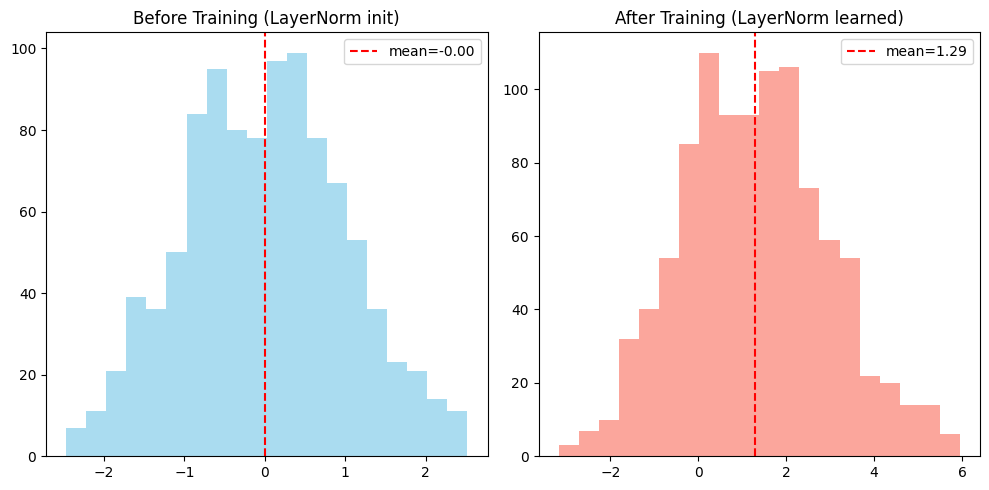

Learned gamma (scale): Parameter containing:
tensor([1.6154, 1.2497, 1.4564, 1.7045, 1.7863, 1.9443, 1.4160, 1.8703, 1.4232,
        1.7412], requires_grad=True)
Learned beta (bias): Parameter containing:
tensor([1.2698, 1.0632, 1.2368, 1.2911, 1.2937, 1.4006, 1.1862, 1.3697, 1.2034,
        1.3023], requires_grad=True)


In [3]:
# ============================
# nn.LayerNormの学習挙動を可視化
# ============================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 再現性のために固定
torch.manual_seed(0)

# 入力データ（バッチサイズ 100, 特徴次元 10）
x = torch.randn(100, 10)

# LayerNorm 層
ln = nn.LayerNorm(10)

# Optimizer（LayerNormのパラメータを学習）
optimizer = torch.optim.SGD(ln.parameters(), lr=0.1)

# ===== 学習前の出力分布 =====
with torch.no_grad():
    y_before = ln(x).detach().clone()

# ===== 学習を模擬 =====
for epoch in range(50):
    optimizer.zero_grad()
    y = ln(x)
    # 出力を「平均0, 分散1」に近づけるのではなく、
    # あえて「出力平均=2, 分散=4」に寄せるようにする
    target_mean = 2.0
    target_std = 2.0
    loss = ((y.mean() - target_mean)**2 + (y.std() - target_std)**2)
    loss.backward()
    optimizer.step()

# ===== 学習後の出力分布 =====
with torch.no_grad():
    y_after = ln(x).detach().clone()

# ============================
# 可視化
# ============================

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Before Training (LayerNorm init)")
plt.hist(y_before.numpy().flatten(), bins=20, color='skyblue', alpha=0.7)
plt.axvline(y_before.mean().item(), color='red', linestyle='--', label=f"mean={y_before.mean():.2f}")
plt.legend()

plt.subplot(1,2,2)
plt.title("After Training (LayerNorm learned)")
plt.hist(y_after.numpy().flatten(), bins=20, color='salmon', alpha=0.7)
plt.axvline(y_after.mean().item(), color='red', linestyle='--', label=f"mean={y_after.mean():.2f}")
plt.legend()

plt.tight_layout()
plt.show()

# ===== 学習されたパラメータを確認 =====
print("Learned gamma (scale):", ln.weight)
print("Learned beta (bias):", ln.bias)


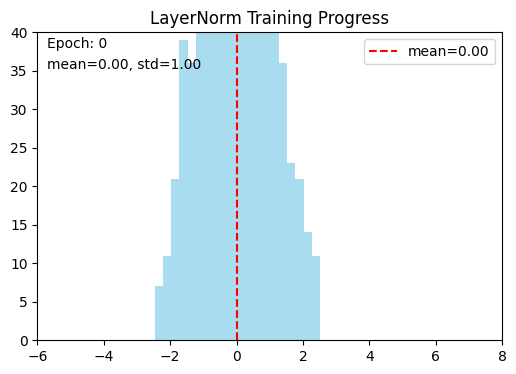

In [4]:
# ============================================
# nn.LayerNorm の学習挙動をアニメーションで可視化
# ============================================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# 再現性のため乱数シード固定
torch.manual_seed(0)

# 入力データ
x = torch.randn(100, 10)

# LayerNorm 層
ln = nn.LayerNorm(10)
optimizer = torch.optim.SGD(ln.parameters(), lr=0.1)

# 学習のターゲット
target_mean = 2.0
target_std = 2.0

# 可視化用に記録
history = []

# ===== 学習ループ =====
for epoch in range(60):
    optimizer.zero_grad()
    y = ln(x)
    loss = ((y.mean() - target_mean)**2 + (y.std() - target_std)**2)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        history.append({
            'epoch': epoch,
            'y': y.detach().clone(),
            'mean': y.mean().item(),
            'std': y.std().item(),
            'gamma': ln.weight.detach().clone(),
            'beta': ln.bias.detach().clone()
        })

# ====== アニメーション ======

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(-6, 8)
ax.set_ylim(0, 40)
ax.set_xlabel("Output value")
ax.set_ylabel("Frequency")
ax.set_title("LayerNorm Training Progress")

hist_data, = ax.plot([], [], lw=2)
text_epoch = ax.text(0.02, 0.95, '', transform=ax.transAxes)
text_stats = ax.text(0.02, 0.88, '', transform=ax.transAxes)

def update(frame):
    ax.clear()
    y = history[frame]['y'].numpy().flatten()
    ax.hist(y, bins=20, color='skyblue', alpha=0.7)
    ax.axvline(y.mean(), color='red', linestyle='--', label=f"mean={y.mean():.2f}")
    ax.set_xlim(-6, 8)
    ax.set_ylim(0, 40)
    ax.legend()
    ax.set_title("LayerNorm Training Progress")
    text_epoch = ax.text(0.02, 0.95, f"Epoch: {frame}", transform=ax.transAxes)
    text_stats = ax.text(0.02, 0.88, f"mean={y.mean():.2f}, std={y.std():.2f}", transform=ax.transAxes)
    return []

ani = FuncAnimation(fig, update, frames=len(history), interval=200, blit=False)
HTML(ani.to_jshtml())
